In [1]:
!mkdir %userprofile%\.kaggle
!copy kaggle.json %userprofile%\.kaggle\

A subdirectory or file C:\Users\001\.kaggle already exists.


        1 file(s) copied.


In [ ]:
!kaggle datasets download -d dmitrybabko/speech-emotion-recognition-en

https://www.kaggle.com/code/shivamburnwal/speech-emotion-recognition/notebook

https://github.com/nicknochnack/DeepAudioClassification/blob/main/AudioClassification.ipynb

In [ ]:
!pip install librosa

In [3]:
import pandas as pd
import numpy as np

import os
import sys

# librosa is a Python library for analyzing audio and music. It can be used to extract the data from the audio files we will see it later.
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# to play the audio files
from IPython.display import Audio

import keras
from keras.callbacks import ReduceLROnPlateau
from keras.models import Sequential
from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
from keras.utils import np_utils, to_categorical
from keras.callbacks import ModelCheckpoint

In [31]:
pd.set_option('display.max_columns', None)
pd.options.display.max_colwidth = 200

In [32]:
Ravdess = "./speech-emotion-recognition-en/Ravdess/audio_speech_actors_01-24/"
Crema = "./speech-emotion-recognition-en/Crema/"
Tess = "./speech-emotion-recognition-en/Tess/"
Savee = "./speech-emotion-recognition-en/Savee/"

# Ravdess Dataset

In [33]:
file_paths_ravdess = []
file_emotions_ravdess = []
actors = os.listdir(Ravdess)
for actor in actors:
    files = os.listdir(Ravdess+actor)
    for file in files:
        file_part = file.split('.')
        file_part_2 = file_part[0].split('-')
        emotion = int(file_part_2[2])
        file_emotions_ravdess.append(emotion)
        file_paths_ravdess.append(Ravdess+actor+'/'+file)
ravdess_df = pd.DataFrame(zip(file_emotions_ravdess,file_paths_ravdess),columns=['Emotions','Paths'])
ravdess_df.Emotions.replace({1:'neutral', 2:'calm', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'}, inplace=True)
ravdess_df.head()

,Emotions,Paths
0,neutral,./speech-emotion-recognition-en/Ravdess/audio_speech_actors_01-24/Actor_01/03-01-01-01-01-01-01.wav
1,neutral,./speech-emotion-recognition-en/Ravdess/audio_speech_actors_01-24/Actor_01/03-01-01-01-01-02-01.wav
2,neutral,./speech-emotion-recognition-en/Ravdess/audio_speech_actors_01-24/Actor_01/03-01-01-01-02-01-01.wav
3,neutral,./speech-emotion-recognition-en/Ravdess/audio_speech_actors_01-24/Actor_01/03-01-01-01-02-02-01.wav
4,calm,./speech-emotion-recognition-en/Ravdess/audio_speech_actors_01-24/Actor_01/03-01-02-01-01-01-01.wav


# Crema Dataset

In [34]:
files = os.listdir(Crema)
file_paths_crema = []
file_emotions_crema = []
for file in files:
    file_part = file.split('.')
    file_part_2 = file_part[0].split('_')
    emotion = file_part_2[2]
    if emotion == 'SAD':
        file_emotions_crema.append('sad')
    elif emotion == 'ANG':
        file_emotions_crema.append('angry')
    elif emotion == 'DIS':
        file_emotions_crema.append('disgust')
    elif emotion == 'FEA':
        file_emotions_crema.append('fear')
    elif emotion == 'HAP':
        file_emotions_crema.append('happy')
    elif emotion == 'NEU':
        file_emotions_crema.append('neutral')
    else:
        file_emotions_crema.append('Unknown')
    file_paths_crema.append(Crema+file)

crema_df = pd.DataFrame(zip(file_emotions_crema,file_paths_crema),columns=['Emotions','Paths'])
crema_df.head()

,Emotions,Paths
0,angry,./speech-emotion-recognition-en/Crema/1001_DFA_ANG_XX.wav
1,disgust,./speech-emotion-recognition-en/Crema/1001_DFA_DIS_XX.wav
2,fear,./speech-emotion-recognition-en/Crema/1001_DFA_FEA_XX.wav
3,happy,./speech-emotion-recognition-en/Crema/1001_DFA_HAP_XX.wav
4,neutral,./speech-emotion-recognition-en/Crema/1001_DFA_NEU_XX.wav


# Tess Dataset

In [56]:
file_paths_tess = []
file_emotions_tess = []
dirs = os.listdir(Tess)
for d in dirs:
    files = os.listdir(Tess+d)
    emotion_from_dir = d.split('_')[-1].lower()
    emotion_from_dir = 'surprise' if emotion_from_dir=='surprised' else emotion_from_dir # because there is a folder named YAF_pleasant_surprised
    file_emotions_tess+=[emotion_from_dir]*len(files)
    for file in files:
        file_paths_tess.append(Tess+d+'/'+file)
tess_df = pd.DataFrame(zip(file_emotions_tess,file_paths_tess),columns=['Emotions','Paths'])

In [57]:
tess_df.sample(10)

,Emotions,Paths
1062,surprise,./speech-emotion-recognition-en/Tess/OAF_Pleasant_surprise/OAF_hole_ps.wav
785,happy,./speech-emotion-recognition-en/Tess/OAF_happy/OAF_walk_happy.wav
1689,disgust,./speech-emotion-recognition-en/Tess/YAF_disgust/YAF_loaf_disgust.wav
535,fear,./speech-emotion-recognition-en/Tess/OAF_Fear/OAF_red_fear.wav
1595,angry,./speech-emotion-recognition-en/Tess/YAF_angry/YAF_witch_angry.wav
2116,happy,./speech-emotion-recognition-en/Tess/YAF_happy/YAF_page_happy.wav
843,neutral,./speech-emotion-recognition-en/Tess/OAF_neutral/OAF_gap_neutral.wav
1269,sad,./speech-emotion-recognition-en/Tess/OAF_Sad/OAF_judge_sad.wav
2650,sad,./speech-emotion-recognition-en/Tess/YAF_sad/YAF_goal_sad.wav
1417,angry,./speech-emotion-recognition-en/Tess/YAF_angry/YAF_chair_angry.wav


# Savee Dataset

In [58]:
savee_directory_list = os.listdir(Savee)

file_emotions_savee = []
file_paths_savee = []

for file in savee_directory_list:
    file_paths_savee.append(Savee + file)
    part = file.split('_')[1]
    ele = part[:-6]
    if ele=='a':
        file_emotions_savee.append('angry')
    elif ele=='d':
        file_emotions_savee.append('disgust')
    elif ele=='f':
        file_emotions_savee.append('fear')
    elif ele=='h':
        file_emotions_savee.append('happy')
    elif ele=='n':
        file_emotions_savee.append('neutral')
    elif ele=='sa':
        file_emotions_savee.append('sad')
    else:
        file_emotions_savee.append('surprise')
        
savee_df = pd.DataFrame(zip(file_emotions_savee,file_paths_savee), columns=['Emotions','Paths'])

In [59]:
savee_df.sample(10)

,Emotions,Paths
78,neutral,./speech-emotion-recognition-en/Savee/DC_n19.wav
13,angry,./speech-emotion-recognition-en/Savee/DC_a14.wav
434,neutral,./speech-emotion-recognition-en/Savee/KL_n15.wav
439,neutral,./speech-emotion-recognition-en/Savee/KL_n20.wav
5,angry,./speech-emotion-recognition-en/Savee/DC_a06.wav
387,disgust,./speech-emotion-recognition-en/Savee/KL_d13.wav
462,sad,./speech-emotion-recognition-en/Savee/KL_sa13.wav
40,fear,./speech-emotion-recognition-en/Savee/DC_f11.wav
332,sad,./speech-emotion-recognition-en/Savee/JK_sa03.wav
436,neutral,./speech-emotion-recognition-en/Savee/KL_n17.wav


# Concatenate whole dataframes

In [60]:
data_df = pd.concat([ravdess_df,crema_df,tess_df,savee_df],axis=0)

In [61]:
data_df.sample(10)

,Emotions,Paths
881,neutral,./speech-emotion-recognition-en/Crema/1011_TSI_NEU_XX.wav
1713,disgust,./speech-emotion-recognition-en/Crema/1022_IEO_DIS_LO.wav
952,surprise,./speech-emotion-recognition-en/Ravdess/audio_speech_actors_01-24/Actor_16/03-01-08-01-01-01-16.wav
5165,neutral,./speech-emotion-recognition-en/Crema/1064_IEO_NEU_XX.wav
664,happy,./speech-emotion-recognition-en/Crema/1009_IEO_HAP_HI.wav
2050,sad,./speech-emotion-recognition-en/Crema/1026_IEO_SAD_HI.wav
2804,disgust,./speech-emotion-recognition-en/Crema/1035_ITS_DIS_XX.wav
2752,sad,./speech-emotion-recognition-en/Tess/YAF_sad/YAF_sheep_sad.wav
2202,angry,./speech-emotion-recognition-en/Crema/1028_IEO_ANG_LO.wav
1114,happy,./speech-emotion-recognition-en/Crema/1014_TAI_HAP_XX.wav


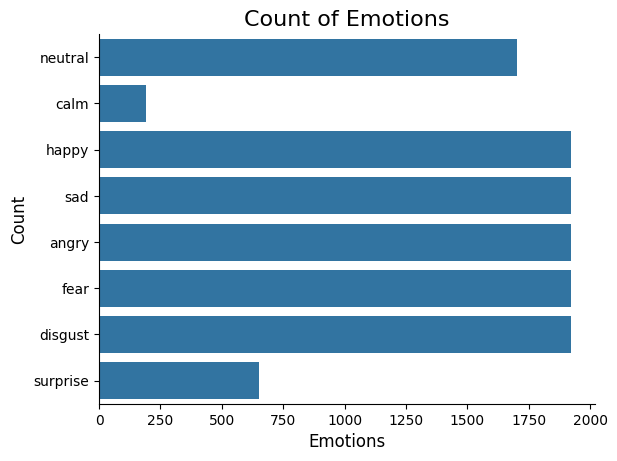

In [66]:
plt.title('Count of Emotions', size=16)
sns.countplot(data_df.Emotions)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()